# MeOH synthesis model comparison (Grabow vs RMG)

Source for grabow model:  
Grabow, L. C., & Mavrikakis, M. (2011). Mechanism of methanol synthesis on cu through CO2 and CO hydrogenation. ACS Catalysis, 1(4), 365–384. https://doi.org/10.1021/cs200055d

In [1]:
import pandas as pd
import numpy as np
import time
import cantera as ct
from matplotlib import pyplot as plt
import csv
import math
import os
import sys
from IPython.display import Image

import itertools
import logging
from collections import defaultdict

import scipy.linalg as la

print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.5.1


### Convert thermo from grabow mechanism (supplementary data text file) 

In [2]:
# import shutil
# # convert mech.txt file 
# grab_file = '../../External_data/mech.txt'
# grab_cti = '../../External_data/mech_grabow.cti'
# grab_new_cti = '../../External_data/mech_grabow_new.cti'
# rec = False
# gas = {}
# surf = {}
# use_corrected = True # column F should be divided by 1e3

# with open(grab_file, "r") as f:
#     for line in f:
#         if "gas" in line:
#             gas_write = True
#         if "surface" in line:
#             surf_write = True 
            
#         if "Species" in line:
#             rec = True
#             continue
            
#         if "end" in line:
#             rec = False
#             gas_write = False
#             surf_write = False
            
#         if rec == True:
#             if gas_write == True:
#                 # skip the reference state enthalpy and entropy (col 1 and 2)
#                 split = list(map(float,line.split()[3:10]))
#                 H = float(line.split()[10])
#                 element = line.split()[0].replace('*','X',1)
                
#                 if use_corrected:
#                     split[5] = split[5]/1000 
#                 else:
#                     split[5] = split[5]-H
                
#                 gas.update({element: split})
#                 print(element, " ", split)
                
#             elif surf_write == True:
#                 split = list(map(float,line.split()[3:10]))
#                 H = float(line.split()[10])
#                 element = line.split()[0].replace('*','X',1)
                
#                 if use_corrected:
#                     split[5] = split[5]/1000 
#                 else:
#                     split[5] = split[5]-H
                
#                 surf.update({element: split})  
#                 print(element, " ", split)
            

### Convert kinetics from grabow

In [3]:
# # convert mech.txt file 
# grab_file = '../../External_data/mech.txt'
# grab_cti = '../../External_data/mech_grabow.cti'
# grab_new_cti = '../../External_data/mech_grabow_new.cti'
# rec = False
# rxn = []

# # constants
# Na = 6.02214e23
# kj2kcal = 0.239006
# ev2kcal = 3.82929e-23
# ev2kcalmol = ev2kcal*Na
# Site_density = 2.9e-09*(100**2) #mol/m^2

# # comment string
# comm_str = "# surface1 Reaction"

# # sticking coefficient multiplier
# # stick_mult = 1.7445309221788237
# stick_mult = 1

# # use activation energy from matlab file? 
# use_act_E = False

# with open(grab_file, "r") as f:
#     for line in f:
#         if line.startswith("end"):
#             break
#         if "reactions" in line:
#             rxn_write = True
#         if line.startswith("R"):
#             rec = True            
#         if rec == True:
#             # skip the reference state enthalpy and entropy (col 1 and 2)
#             split = list(line.split()[2:])
#             reaction = line.split()[1].replace('*','X').replace("->", " <=> ").replace("+", " + ").replace(" 2X", " 2 X").replace("2HX", "2 HX").replace("2OHX <", "2 OHX <").replace("2CH2OX <", "2 CH2OX <")
#             if len(split) > 3:
#                 split[3] = float(split[3])/Site_density
#                 split[2] = float(split[2])*ev2kcalmol
#                 reaction = f"surface_reaction('{reaction}', [{split[3]}, 0.0, {split[2]}])"
                
#             elif len(split) <= 2:
#                 split[1] = float(split[1])*stick_mult
#                 reaction = f"surface_reaction('{reaction}', stick({split[1]}, 0.0, 0.0))"
                
#             elif len(split) == 3:
#                 split[2] = float(split[2])*stick_mult
#                 if use_act_E == True: 
#                     split[1] = float(split[1])*kj2kcal
#                     reaction = f"surface_reaction('{reaction}', stick({split[2]}, 0.0, {split[1]}))"
#                 else: 
#                     reaction = f"surface_reaction('{reaction}', stick({split[2]}, 0.0, 0.0))"                      
#             rxn.append(reaction)

### write 

In [4]:
# gas.update(surf)
# spec_write = False
# rxnnum = 0

# with open(grab_cti) as old, open(grab_new_cti, "w") as new :
#     for line in old:
# #         if "species(name=" in line and not "species(name='X'" in line:        
#         if "species(name=" in line:
#             spec = line[13:].strip().replace(",","").replace("'", "")
#             new.write(line)
#         elif "thermo=(Shomate([200.00, 1000.00]," in line:
#             new.write(line)
#             spec_write = True
#             continue
#         elif spec_write == True:
#             spec_write = False
#             converted_list= [str(element) for element in gas[spec]]
#             joined_string = ",".join(converted_list)
#             joined_string = "                     ["+joined_string+"])))"
#             new.write(joined_string) 
#         elif "surface_reaction" in line:
#             new.write(rxn[rxnnum] + "\n")
#             print(rxnnum + 1, " : " ,rxn[rxnnum])
#             rxnnum+=1
#         else:
#             new.write(line)

In [20]:
# Grabow model and RMG input files
cti_file_grab = '../../External_data/mech_grabow_new.cti'
cti_file_rmg = '/work/westgroup/ChrisB/meoh-synthesis_RMG/meOH-synthesis/base/cantera/chem_annotated.cti'
cti_file_bjarne = '../../External_data/Bjarne_thermo/chemNi111DFT.cti'

if not os.path.exists(cti_file_rmg):
    cti_file_rmg = cti_file_grab # Just use the grabow model twice
    
# set initial temps, pressures, concentrations
temp = 483.5                # [kelvin]
pressure = 15.3*1e5         # [Pascals] 

# CO/CO2/H2/H2O: typical is 
# concentrations = {'CO(3)': X_co,'CO2(4)': X_co2, 'H2(2)':X_h2}
# cov = {'X(1)':}

# initialize cantera gas and surface
gas_grab = ct.Solution(cti_file_grab,'gas', basis="molar")
gas_RMG = ct.Solution(cti_file_rmg,'gas', basis="molar")
gas_bjarne = ct.Solution(cti_file_bjarne,'gas', basis="molar")

# surf_grab = ct.Interface(cti_file,'surface1_grab', [gas_grab])
surf_grab = ct.Interface(cti_file_grab,'surface1', [gas_grab], basis="molar")
surf_RMG = ct.Interface(cti_file_rmg,'surface1', [gas_RMG], basis="molar")
surf_bjarne = ct.Interface(cti_file_bjarne,'surface1', [gas_RMG], basis="molar")

gas_grab.TP = temp, pressure
surf_grab.TP = temp, pressure

gas_RMG.TP = temp, pressure
surf_RMG.TP = temp, pressure

gas_bjarne.TP = temp, pressure
surf_bjarne.TP = temp, pressure

### Thermo Comparison 
How does RMG determine reference states for thermo? how does grabow? 
RMG - pp 214 of RMG paper, and 9972 of RMG-Cat paper. the calculation for gas phase is gas phase species at 298K, 
Surface species are determined by:  


$X_{adsorbate} = X_{gas-phase} + \Delta X_{adsorption}$


$X = \Delta H_f^o(298K), S^o(298K), Cp(T)$

Grabow I could not find much, but their paper says the "zero-energy binding energy reference" corresponds to the gas phase adsorbate at infinite separation from the Cu(111) surface

RMG - https://doi.org/10.1016/j.cpc.2016.02.013

RMG-Cat - https://doi.org/10.1021/acs.jpcc.7b02133

## thermo comparison

In [13]:
gas_dict = {}
surf_dict = {}

gas_unmatched = {}
surf_unmatched = {}

# map rmg names to grabow names in a dictionary
# 
for i in gas_grab.species_names:
    for j in gas_RMG.species_names:
        spec_rmg = j.split("(", 1)[0] 
        if i == spec_rmg:
            gas_dict.update({j:i})

for i in surf_grab.species_names:
    for j in surf_RMG.species_names:
        spec_rmg = j.replace("*", "X").split("(", 1)[0] 
#         if i == spec_rmg and i != "X":
        if i == spec_rmg:
            surf_dict.update({j:i})


<ipython-input-14-36438913eaa3>:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,3,figsize=(15,5))


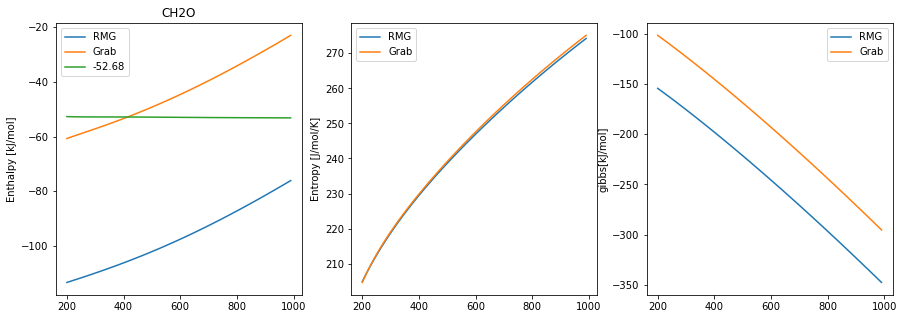

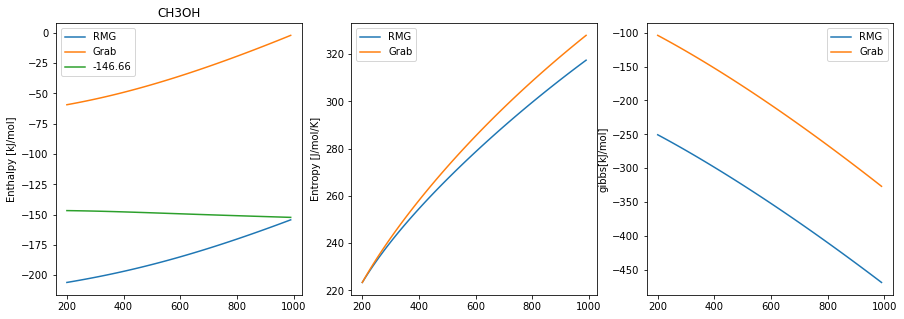

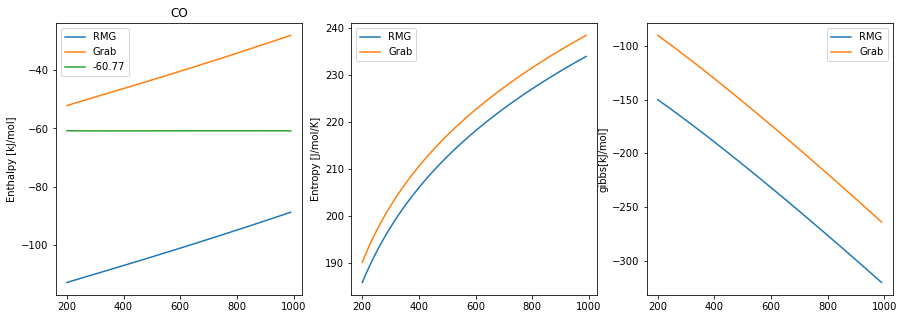

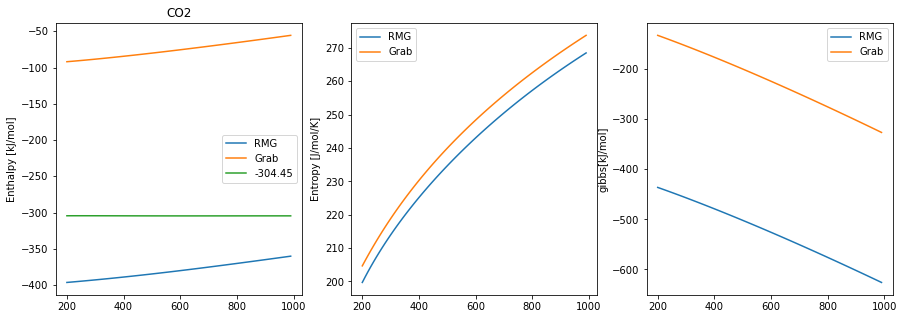

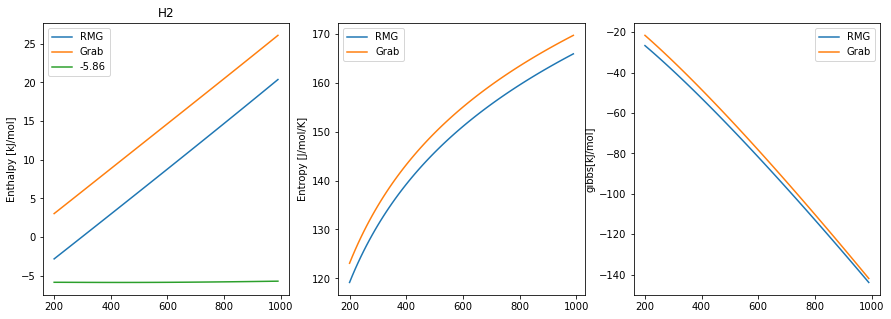

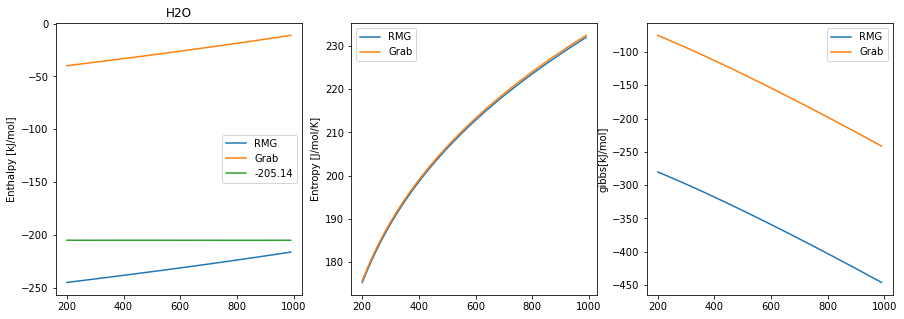

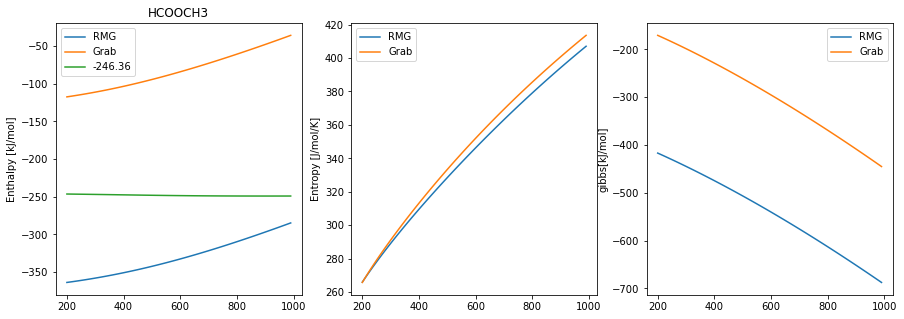

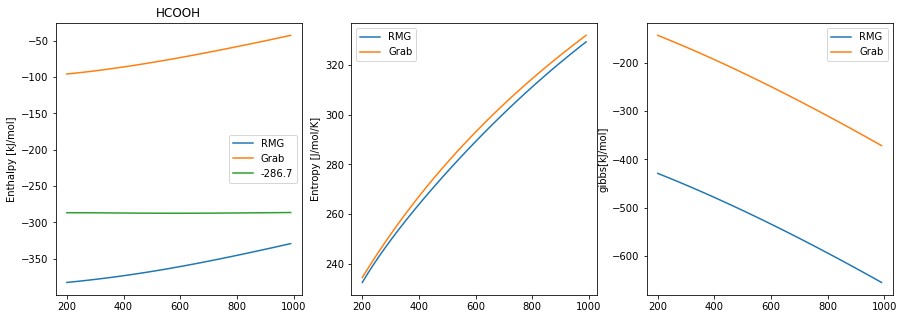

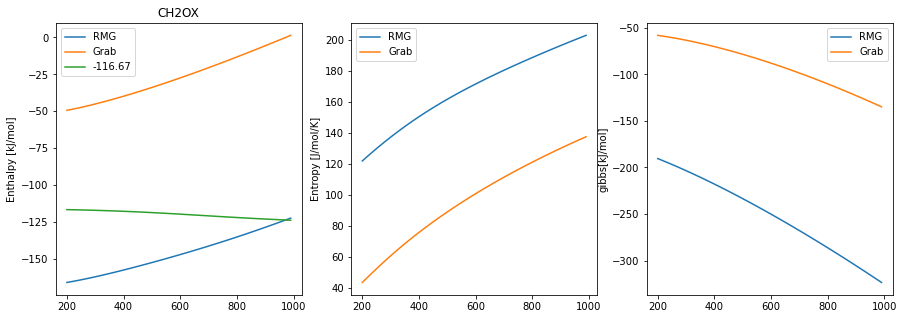

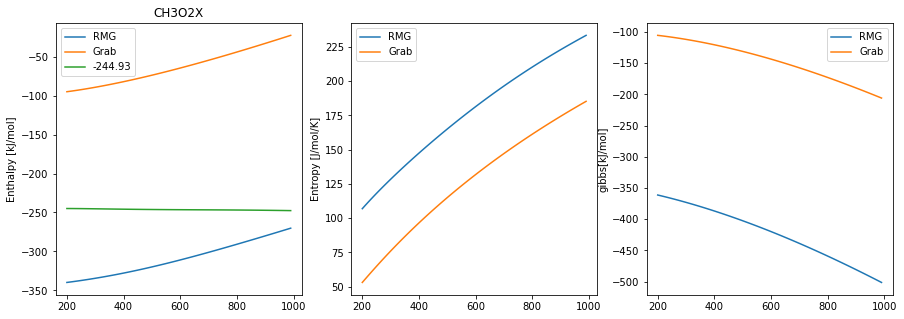

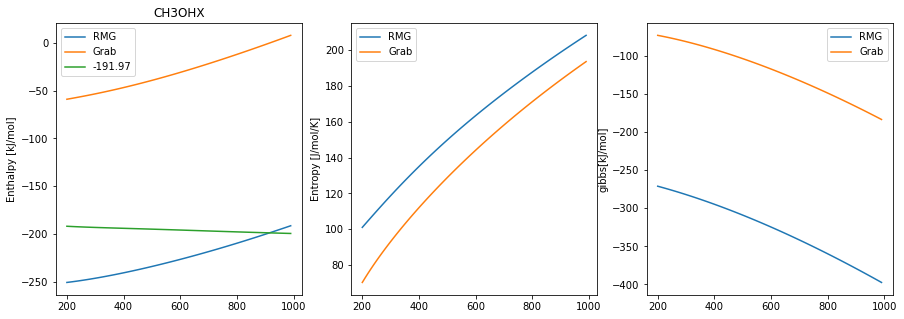

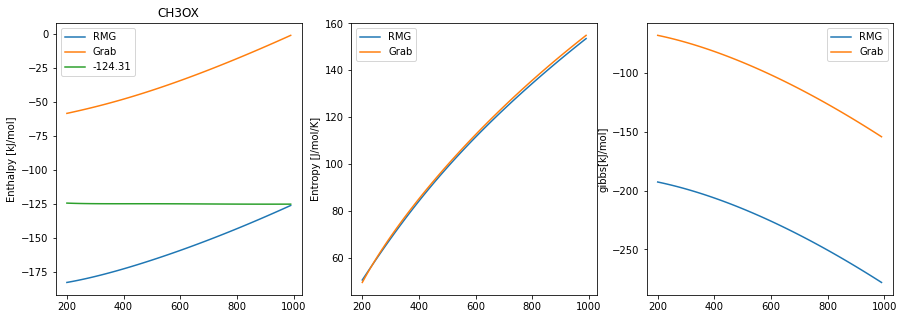

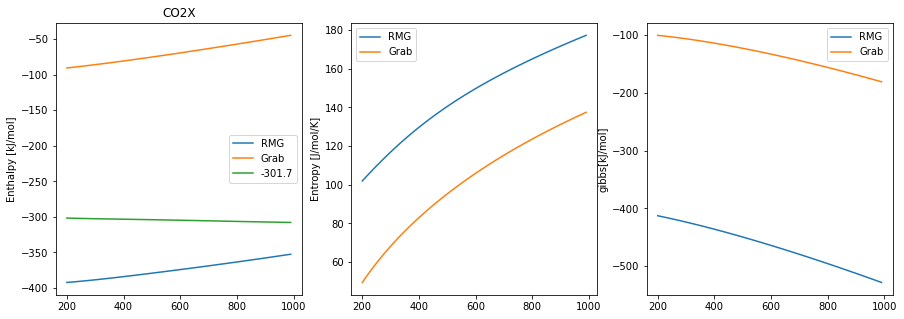

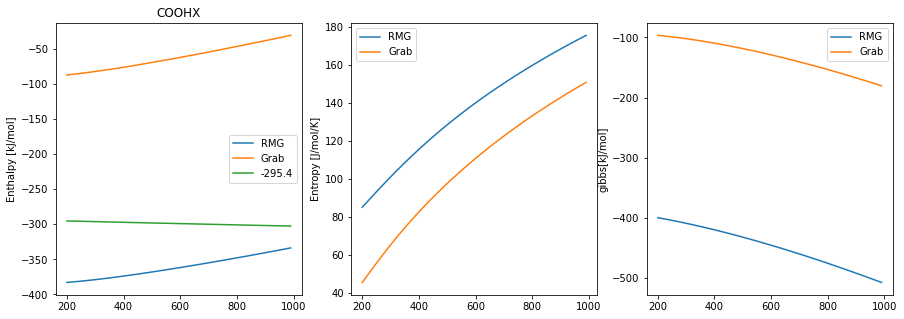

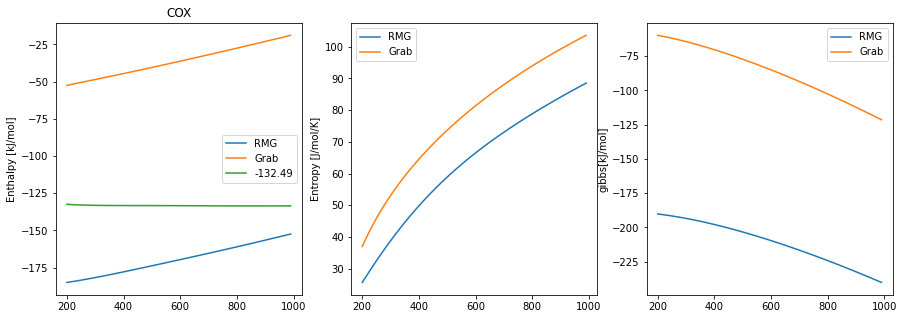

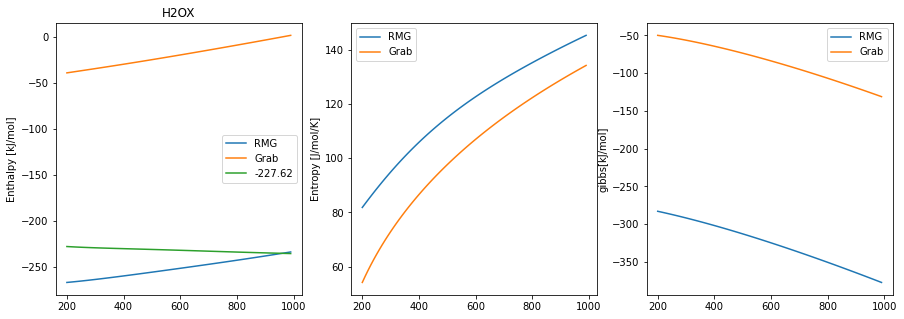

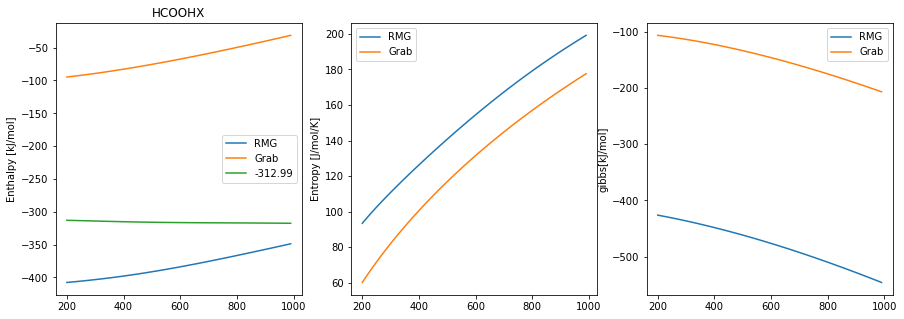

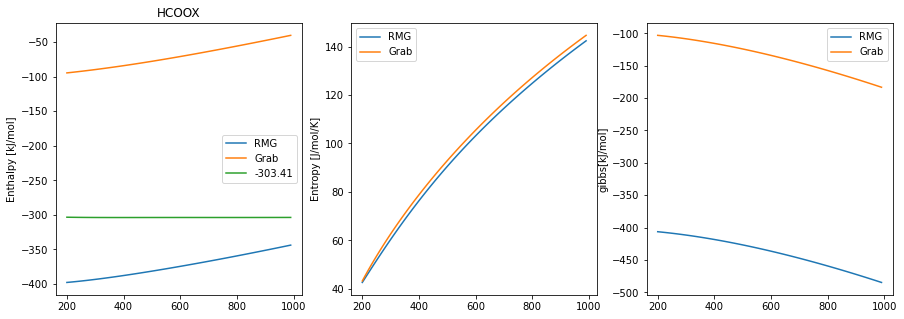

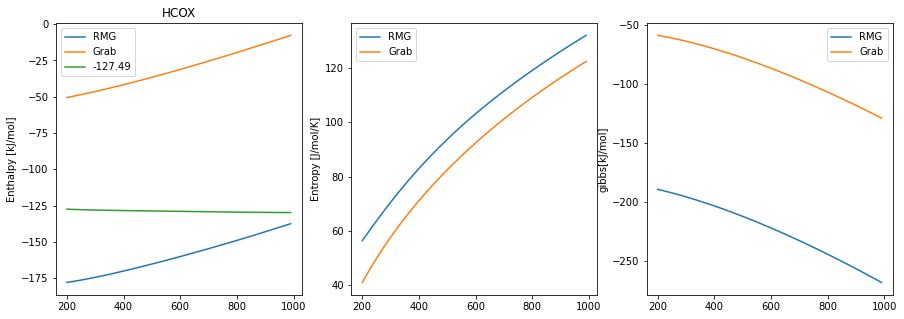

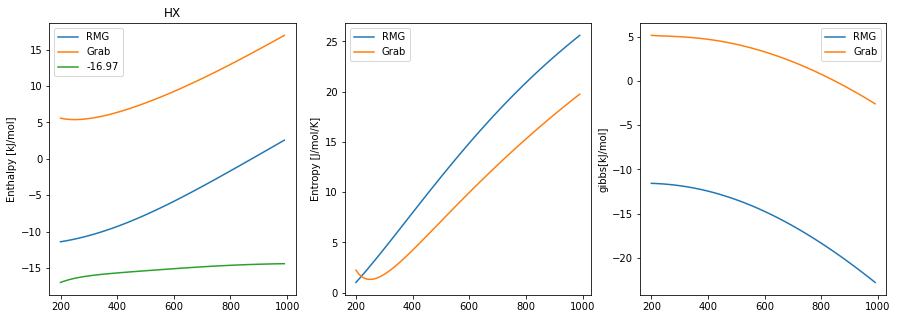

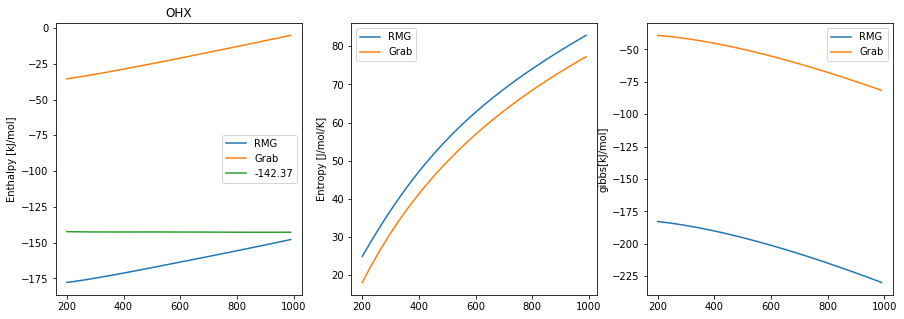

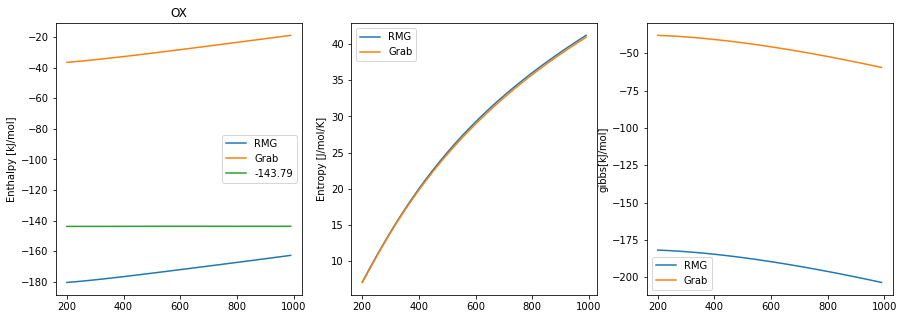

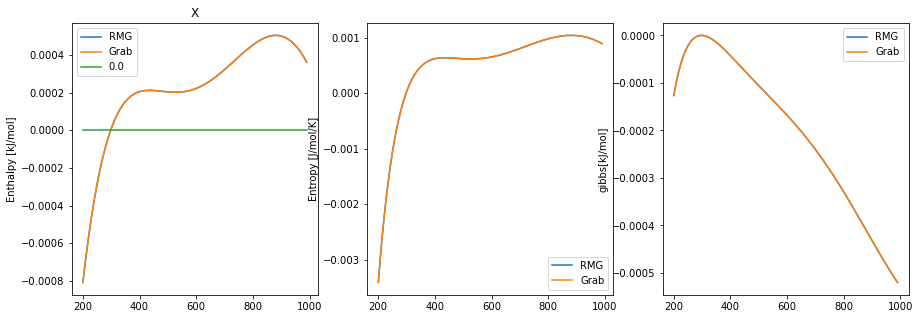

In [14]:
def plot_thermo(species, trange, phase):
    # plot thermo for 1 species
    # speciesX = string
    # trange = np range
    # phase = ct phase object
    # initialize thermo

    h = []
    s = []
    g = []

    for i in temp_array:
        # cantera reports H in J/Kmol, so multiply by 2.39006e-7 to get 
        # Kcal/mol and 2.39006e-4 to get cal/mol (to compare to RMG.MIT.edu)
        h.append(phase.species(species).thermo.h(i)* 1e-6) # to get kcal: *2.39006e-7)
        s.append(phase.species(species).thermo.s(i)* 1e-3) # to get kcal: *2.39006e-4)
        g.append((phase.species(species).thermo.h(i) - \
                      i*phase.species(species).thermo.s(i))* 1e-6) # to get kcal: *2.39006e-7)

    fig, ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].plot(temp_array, h)
    ax[0].set_title(species)
    ax[0].set_ylabel("Enthalpy [kJ/mol]")

    ax[1].plot(temp_array, s)
    ax[1].set_ylabel("Entropy [J/mol/K]")

    ax[2].plot(temp_array, g)
    ax[2].set_ylabel("gibbs[kJ/mol]")
    
def plot_thermo_compare(species_RMG, species_Grab, trange, phase_rmg, phase_grab):
    # plot thermo for two species for comparison
    # speciesX = string
    # trange = np range
    # phase = ct phase object

    # initialize thermo

    h_rmg = []
    h_grab = []
    s_rmg = []
    s_grab = []
    g_rmg = []
    g_grab = []

    for i in temp_array:
        # cantera reports H in J/Kmol, so multiply by 2.39006e-7 to get 
        # Kcal/mol and 2.39006e-4 to get cal/mol (to compare to RMG.MIT.edu)
        h_rmg.append(phase_rmg.species(species_RMG).thermo.h(i)* 1e-6) # to get kcal: *2.39006e-7)
        h_grab.append(phase_grab.species(species_Grab).thermo.h(i)* 1e-6) # to get kcal: *2.39006e-7)
        s_rmg.append(phase_rmg.species(species_RMG).thermo.s(i)* 1e-3) # to get kcal: *2.39006e-4)
        s_grab.append(phase_grab.species(species_Grab).thermo.s(i)* 1e-3) # to get kcal: *2.39006e-4)
        g_rmg.append((phase_rmg.species(species_RMG).thermo.h(i) - \
                      i*phase_rmg.species(species_RMG).thermo.s(i))* 1e-6) # to get kcal: *2.39006e-7)
        g_grab.append((phase_grab.species(species_Grab).thermo.h(i) - \
                       i*phase_grab.species(species_Grab).thermo.s(i))* 1e-6) # to get kcal: *2.39006e-7)

    h_diff = [(i-j) for i, j in zip(h_rmg, h_grab)]    
        
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].plot(temp_array, h_rmg, label="RMG")
    ax[0].set_title(species_Grab)
    ax[0].set_ylabel("Enthalpy [kJ/mol]")
    ax[0].plot(temp_array, h_grab, label="Grab")
    ax[0].plot(temp_array, h_diff, label=round(h_diff[0],2))
    ax[0].legend()

    ax[1].plot(temp_array, s_rmg, label="RMG")
    ax[1].set_ylabel("Entropy [J/mol/K]")
    ax[1].plot(temp_array, s_grab, label="Grab")
    ax[1].legend()

    ax[2].plot(temp_array, g_rmg, label="RMG")
    ax[2].set_ylabel("gibbs[kJ/mol]")
    ax[2].plot(temp_array, g_grab, label="Grab")
    ax[2].legend()



temp_array = np.arange(200, 1000, 10)

for i in gas_dict.keys():
    plot_thermo_compare(i, gas_dict[i], temp_array, gas_RMG, gas_grab)
    
for i in surf_dict.keys():
    plot_thermo_compare(i, surf_dict[i], temp_array, surf_RMG, surf_grab)


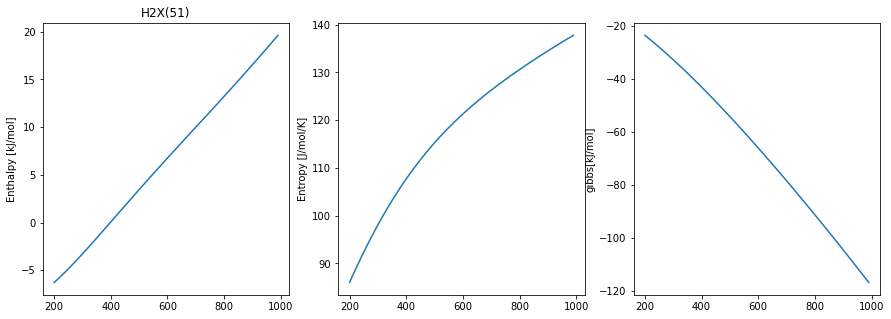

In [21]:
plot_thermo("H2X(51)", temp_array, surf_RMG)

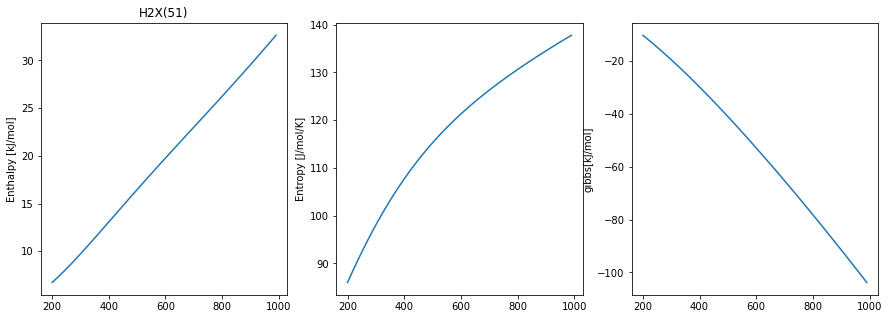

In [19]:
plot_thermo("H2X(51)", temp_array, surf_RMG)

In [ ]:
# COX

species_name = 'CO*(14)'
gas_species_name = 'CO'

# Check our parameters are the same
shomate = surf_grab.species(surf_dict[species_name]).thermo
print("cantera low T    ", shomate.coeffs[1:8])
print("cantera high T   ", shomate.coeffs[8:])
print("our coefficients ", np.array(gas[gas_species_name]))


plot_thermo_compare(species_name, surf_dict[species_name], temp_array, surf_RMG, surf_grab)

a,b,c,d,e,f,g = gas[gas_species_name] 
T = 298.15
t = T/1000.
H = a*t + b*t*t/2. + c*t*t*t/3. + d*t*t*t*t/4. - e/t + f
print(f"Our calculation: {H} kJ/mol")

cantera_H = surf_grab.species(surf_dict[species_name]).thermo.h(T)* 1e-6
print(f"Cantera calculation: {cantera_H} kJ/mol")

H - cantera_H

But the enthalpy of formation of CO* at 298K according to Grabow is -57 kJ/mol.

Their reported Shomate parameters are *before* they add the "fitting" corrections. Which are in a separate column in their matlab file, but not reported in the published SI.

In [ ]:
H-10.64

## RMG SURFACE THERMO

In [ ]:
gas_RMG.species_names

In [ ]:
h_co = gas_grab.species("CO").thermo.h(483.5)#*2.39006e-7

In [ ]:
h_cox = surf_grab.species("COX").thermo.h(483.5)#*2.39006e-7

In [ ]:
h_x = surf_grab.species("X").thermo.h(483.5)#*2.39006e-7

In [ ]:
result = (h_cox)-(h_co+h_x)
print(result)

In [11]:
for i in surf_RMG.species_names:
    plot_thermo(i, temp_array, surf_RMG)

NameError: name 'plot_thermo' is not defined

In [ ]:
for i in surf_grab.species_names:
    plot_thermo(i, temp_array, surf_grab)

## Equilibrium analysis

Get the problem equilibrium constants 

$\Delta G^o = RTln(K_{eq})$

$K_{eq} = e^{-\Delta G^o/RT }$

Entropy change with pressure: 

$\Delta S = Rln(\frac{P_1}{P_2})$

### Conversion from Kc (units) to Kp (unitless?)

In [ ]:
Image(filename='../images/Kc_2_Kp.png',width = 700, height = 300)

In [ ]:
# reaction H2 vdw
# get gibbs for a species
def get_gibbs(species, phase, temp):
    spec_i = phase.species_index(species)
    print(phase.species(spec_i).thermo.reference_pressure)
    g = phase.species(spec_i).thermo.h(temp) - temp*phase.species(spec_i).thermo.s(temp)
    return g

def get_h(species, phase, temp):
    spec_i = phase.species_index(species)
    h = phase.species(spec_i).thermo.h(temp)
    return h

def get_s(species, phase, temp):
    spec_i = phase.species_index(species)
    s = phase.species(spec_i).thermo.s(temp)
    return s

temp_rxn = 500
pressure = ct.one_atm*15
R = ct.gas_constant #J/mol K

gas_RMG.TP = temp_rxn, pressure
surf_RMG.TP = temp_rxn, pressure

print(surf_RMG.reaction_equation(126))
print("cantera Equilibrium Constant:  ", surf_RMG.equilibrium_constants[126])

dg = surf_RMG.delta_standard_enthalpy[126] - temp_rxn*surf_RMG.delta_standard_entropy[126]

H2_s = "H2(2)"
X_s = "X(1)"
H2X_s = "H2X(51)"

H2_g = get_gibbs(H2_s, gas_RMG, temp_rxn)
X_g = get_gibbs(X_s, surf_RMG, temp_rxn)
H2X_g = get_gibbs(H2X_s, surf_RMG, temp_rxn)

H2_ent = get_s(H2_s, gas_RMG, temp_rxn)
X_ent = get_s(X_s, surf_RMG, temp_rxn)
H2X_ent = get_s(H2X_s, surf_RMG, temp_rxn)

H2_h = get_h(H2_s, gas_RMG, temp_rxn)
X_h = get_h(X_s, surf_RMG, temp_rxn)
H2X_h = get_h(H2X_s, surf_RMG, temp_rxn)

deltaG = (H2X_g - (X_g + H2_g)) # J/kmol to [J/mol]
deltaS = (H2X_ent - (X_ent + H2_ent)) # J/kmol 
deltaH = (H2X_h - (X_h + H2_h)) # J/kmol 

print("delta S (std) cantera vs calculated ", surf_RMG.delta_standard_entropy[126], " ", deltaS)
print("delta S cantera vs calculated ", surf_RMG.delta_entropy[126], " ", deltaS)
print("delta H cantera vs calculated ", surf_RMG.delta_standard_enthalpy[126], " ", deltaH)

print("cantera delta gibbs", surf_RMG.delta_standard_gibbs[126], "  ",  dg)
print("calculated delta g", deltaG)

Keq = np.exp(-deltaG/(R*temp_rxn))

print("calculated Equilibrium constant: ", Keq)
print(-10249.454797626066+32820.64200775203)

print(H2_ent)
print(X_ent)
print(H2X_ent)

In [ ]:
print(-87062.04116375049+109633.22837387651)

print(R*temp_rxn)

## plot rxn thermo

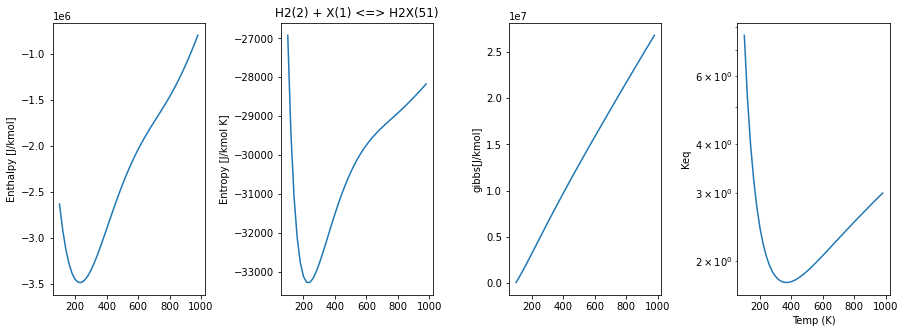

In [24]:
def plot_rxn_thermo(rxn_id, trange, phase, phase2):
    # plot thermo for 1 species
    # speciesX = string
    # trange = np range
    # phase = ct phase object

    # initialize thermo

    h = []
    s = []
    g = []
    k = []
    
    for i in temp_array:
        # cantera reports H in J/Kmol, so multiply by 2.39006e-7 to get 
        # Kcal/mol and 2.39006e-4 to get cal/mol (to compare to RMG.MIT.edu)
        pressure = ct.one_atm
        phase.TP = i, pressure
        phase2.TP = i, pressure
        
        h.append(phase.delta_standard_enthalpy[rxn_id])
        s.append(phase.delta_standard_entropy[rxn_id])
        g.append((phase.delta_standard_gibbs[rxn_id]))
        k.append((phase.equilibrium_constants[rxn_id]))

    fig, ax = plt.subplots(1,4,figsize=(15,5))
    fig.subplots_adjust(wspace=0.5)
                 
    ax[0].plot(temp_array, h)
    ax[0].set_ylabel("Enthalpy [J/kmol]")

    ax[1].plot(temp_array, s)
    ax[1].set_title(phase.reaction_equation(rxn_id))
    ax[1].set_ylabel("Entropy [J/kmol K]")

    ax[2].plot(temp_array, g)
    ax[2].set_ylabel("gibbs[J/kmol]")
    
    ax[3].plot(temp_array, k)
    ax[3].set_ylabel("Keq")
    ax[3].set_yscale("log")
    ax[3].set_xlabel("Temp (K)")

temp_array = np.arange(100, 1000, 20)
plot_rxn_thermo(108, temp_array, surf_RMG, gas_RMG)  
  

In [10]:
Ev_JKmol = 1.60218e-19*6.022e23*1e3 # conversion eV/molecule to J/kmol
H2BE_ev = -0.08 # ev
H2BE_Jkmol = H2BE_ev*Ev_JKmol # Joules/kmol

print("Energy change when H2 is VdW adsorbed is {:.2E} [J/kmol]".format(H2BE_Jkmol))


Energy change when H2 is VdW adsorbed is -7.72E+06 [J/kmol]


In [ ]:
Coefficients = surf_RMG.species(surf_RMG.species_index("H2X(51)")).thermo.coeffs
surf_RMG.species(surf_RMG.species_index("H2X(51)")).thermo(coeffs=Coefficients)

## check COOH against Bjarne's values

In [ ]:
surf_RMG.species_names

In [ ]:
RMG_thermo = surf_RMG.species(surf_RMG.species_index("COOH*(18)")).thermo

In [ ]:
plot_thermo("CHO2X", temp_array, surf_bjarne)
plot_thermo("COOH*(18)", temp_array, surf_RMG)

Our estimated data compared to Bjarne's for CO2 vdw

In [ ]:
plot_thermo_compare("CO2X", "CO2*(15)", temp_array, surf_bjarne, surf_RMG)

Bjarne's data compared to our data for formate

In [ ]:
plot_thermo_compare("CHO2X", "HCOOX", temp_array, surf_bjarne, surf_grab)

In [ ]:
    S = phase.species(species)
    thermo_orig = S.thermo
    coeffs = thermo_orig.coeffs
    coeffs[[6, 13]] += dH / ct.gas_constant
    thermo_new = ct.NasaPoly2(
        thermo_orig.min_temp,
        thermo_orig.max_temp,
        thermo_orig.reference_pressure,
        coeffs,
    )
    S.thermo = thermo_new
    phase.modify_species(phase.species_index(species), S)

# Investigate CH4 surface coverage vs German et al paper 

Predicting CH4 dissociation kinetics on metals: Trends, sticking coefficients, h tunneling, and kinetic isotope effect
DOI: 10.1021/jp406937r